Practice is fully based on the nice jupyter book "Causal Inference for The Brave and True". Here it is: https://matheusfacure.github.io/python-causality-handbook/landing-page.html

data can be found there: https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true/data


# 7.5 Regression Discontinuity Design

We don't stop to think about it much, but it is impressive how smooth nature is. You can't grow a tree without first getting a bud, you can't teleport from one place to another, a wound takes its time to heal. Even in the social realm, smoothness seems to be the norm. You can't grow a business in one day, consistency and hard work are required to build wealth and it takes years before you learn how linear regression works. Under normal circumstances, nature is very cohesive and doesn't jump around much.

Which means that **when we do see jumps and spikes, they are probably artificial** and often man-made situations. These events are usually accompanied by counterfactuals to the normal way of things: if a weird thing happens, this gives us some insight into what would have happened if nature was to work in a different way. Exploring these artificial jumps is at the core of Regression Discontinuity Design.



## Idea of RDD
The basic setup goes like this. Imagine that you have a treatment variable $T$ and potential outcomes $Y_0$ and $Y_1$. The treatment T is a discontinuous function of an observed running variable $R$ such that

$
D_i = \mathcal{1}\{R_i>c\}
$

In other words, this is saying that treatment is zero when $R$ is below a threshold $c$ and one otherwise. This means that we get to observe $Y_1$ when $R>c$ and $Y_0$ when $R<c$. To wrap our head around this, think about the potential outcomes as 2 functions that we can't observe entirely. Both $Y_0(R)$ and $Y_1(R)$ are there, we just can't see that. The threshold acts as a switch that allows us to see one or the other of those function, but never both, much like in the image below:

![img](rdd/rdd.png)

The idea of regression discontinuity is to compare the outcome just above and just below the threshold to identify the treatment effect at the threshold. This is called a **sharp RD** design, since the probability of getting the treatment jumps from 0 to 1 at the threshold, but we could also think about a **fuzzy RD** design, where the probability also jumps, but is a less dramatic manner.



## Example of RDD: Is Alcohol Killing You?

A very relevant public policy question is what should be the minimal drinking age. Most countries, Brazil included, set it to be 18 year, but in the US (most states) it is currently 21. So, is it the case that the US is being overly prudent and that they should lower their minimal drinking age? Or is it the case that other countries should make their legal drinking age higher? 

One way to look at this question is from a [mortality rate perspective (Carpenter and Dobkin, 2009)](https://www.aeaweb.org/articles?id=10.1257/app.1.1.164). From the public policy standpoint, one could argue that we should lower the mortality rate as much as possible. If alcohol consumption increases the mortality rate by a lot, we should avoid lowering the minimum drinking age. This would be consistent with the objective of lowering deaths caused by alcohol consumption.

To estimate the impacts of alcohol on death, we could use the fact that legal drinking age imposes a discontinuity on nature. In the US, those just under 21 years don't drink (or drink much less) while those just older than 21 do drink. This means that the probability of drinking jumps at 21 years and that is something we can explore with an RDD.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

# style.use("fivethirtyeight")

To do so we can grab some mortality data aggregated by age. Each row is the average age of a group of people and the average mortality by all causes (`all`), by moving vehicle accident (`mva`) and by suicide (`suicide`). 

In [3]:
drinking = pd.read_csv("data_book/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


Just to aid visibility (and for another important reason we will see later) we will centralize the running variable `agecell` at the threshold 21.

In [6]:
drinking["agecell"] -= 21

If we plot the multiple outcome variables (`all`, `mva`, `suicide`) with the runing variable on the x axis, we get some visual cue about some sort of jump in mortality as we cross the legal drinking age.

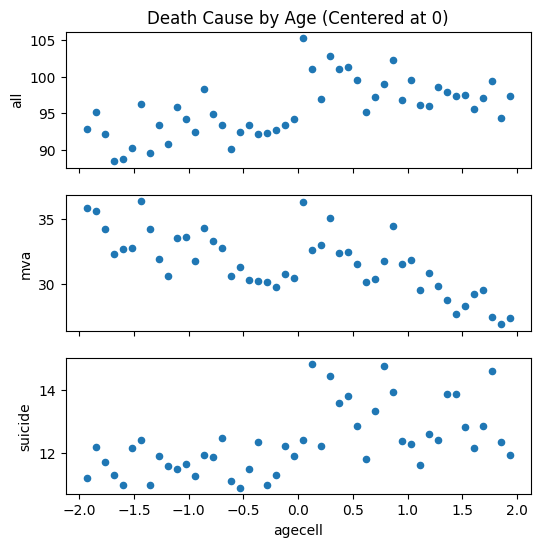

In [7]:
plt.figure(figsize=(6,6))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);

There are some cues, but we need more than that. What exactly is the effect of drinking on mortality at the threshold? And what is the standard error on that estimate?

## RDD Estimation

The key assumption that RDD relies on is the smoothness of the potential outcome at the threshold. Formally, the limits of the potential outcomes as the running variable approaches the threshold from the right and from the left should be the same.

$$
\lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r]
$$

If this holds true, we can find the causal effect at the threshold

$$
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
$$

This is, in its own way, a sort of Local Average Treatment Effect (LATE), since we can only know it at the threshold. In this setting, we can think of RDD as a local randomized trial. For those at the threshold, the treatment could have gone either way and, by chance, some people fell below the threshold, and some people fell above. In our example, at the same point in time, some people are just above 21 years and some people are just below 21. What determines this is if someone was born some days later or not, which is pretty random. For this reason, RDD provides a very compelling causal story. It is not the golden standard of RCT, but it is close. 

Now, to estimate the treatment effect at the threshold, all we need to do is estimate both of the limits in the formula above and compare them. The simplest way to do that is by running a linear regression


To make it work, we interact a dummy for being above the threshold with the running variable

$
y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i
$

Essentially, this is the same as fitting a linear regression above the threshold and another below it. The parameter $\beta_0$ is the intercept of the regression below the threshold and $\beta_0+\beta_2$ is the intercept for the regression above the threshold.

Here is where the trick of centering the running variable at the threshold comes into play. After this pre-processing step, the threshold becomes zero. This causes the intercept $\beta_0$ to be the predicted value at the threshold, for the regression below it. In other words, $\beta_0=\lim_{r \to c^-} E[Y_{ti}|R_i=r]$. By the same reasoning, $\beta_0+\beta_2$ is the limit of the outcome from above. Wich means, that

$
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]
$

Here is what this looks like in code for the case where we want to estimate the effect of alcohol consumption on death by all causes at 21 years.

In [8]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all ~ agecell * threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


This model is telling us that mortality increases by 7.6627 points with the consumption of alcohol. Another way of putting this is that alcohol increases the chance of death by all causes by 8% (100*((7.6627+93.6184)/93.6184 - 1)). Notice that this also gives us standard errors for our causal effect estimate. In this case, the effect is statistically significant, since the p-value is below 0.01.

If we want to verify this model visually, we can show the predicted values on the data that we have. You can see that it is as though we had 2 regression models: one for those above the threshold and one for below it.

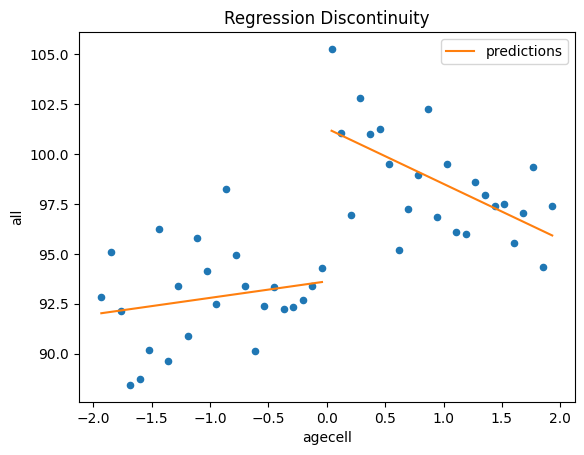

In [9]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

If we do the same for the other causes, this is what we get.

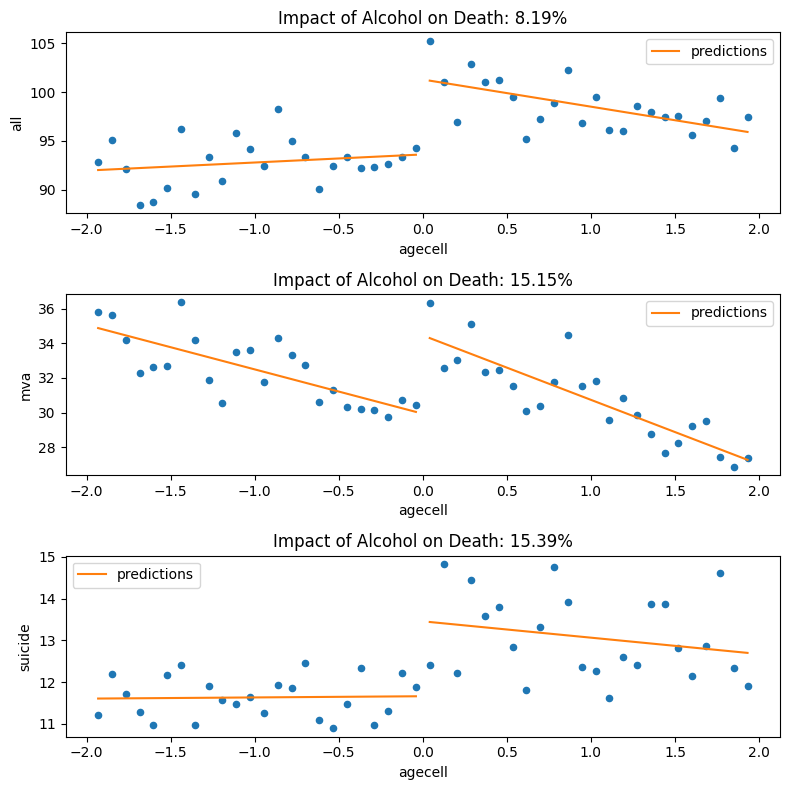

In [10]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

RDD is telling us that alcohol increases the chance of death by suicide and car accidents by 15%, which is a pretty significant amount. These results are compelling arguments to not lower the drinking age, if we want to minimize mortality rates.

### Kernel Weighting

Regression Discontinuity relies heavily on the extrapolations properties of linear regression. Since we are looking at the values at the beginning and end of 2 regression lines, we better get those limits right. What can happen is that regression might focus too much on fitting the other data points at the cost of a poor fit at the threshold. If this happens, we might get the wrong measure of the treatment effect.

One way to solve this is to give higher weights for the points that are closer to the threshold. There are many ways to do this, but a popular one is to reweight the samples with the **triangular kernel**

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

The first part of this kernel is an indicator function to whether we are close to the threshold. How close? This is determined by a bandwidth parameter $h$. The second part of this kernel is a weighting function. As we move away from the threshold, the weights get smaller and smaller. These weights are divided by the bandwidth. If the bandwidth is large, the weights get smaller at a slower rate. If the bandwidth is small, the weights quickly go to zero. 

To make it easier to understand, here is what the weights look like for this kernel applied to our problem. I've set the bandwidth to be 1 here, meaning we will only consider data from people that are no older than 22 years and no younger than 20 years.

In [11]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

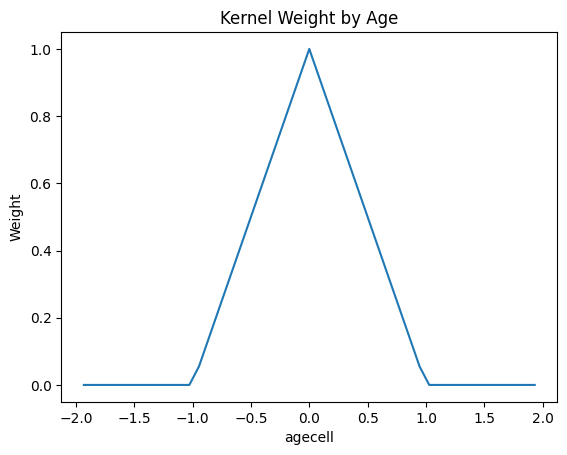

In [12]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

If we apply these weights to our original problem, the impact of alcohol gets bigger, at least for all causes. It jumps from 7.6627 to 9.7004. The result remains very significant. Also, notice that I'm using `wls` instead of `ols`

In [13]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


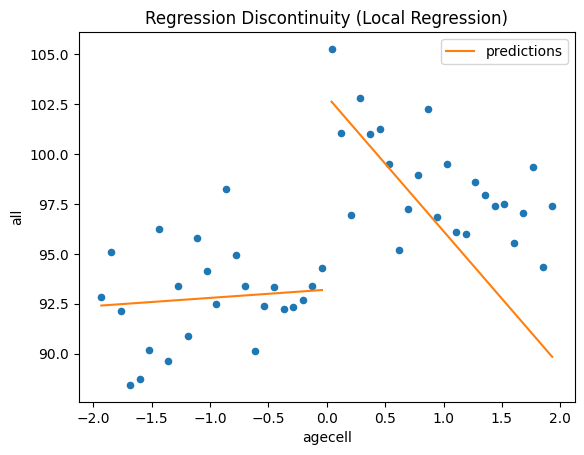

In [14]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

And here is what it looks like for the other causes of death. Notice how the regression on the right is more negatively sloped since it disconsiders the right most points. 

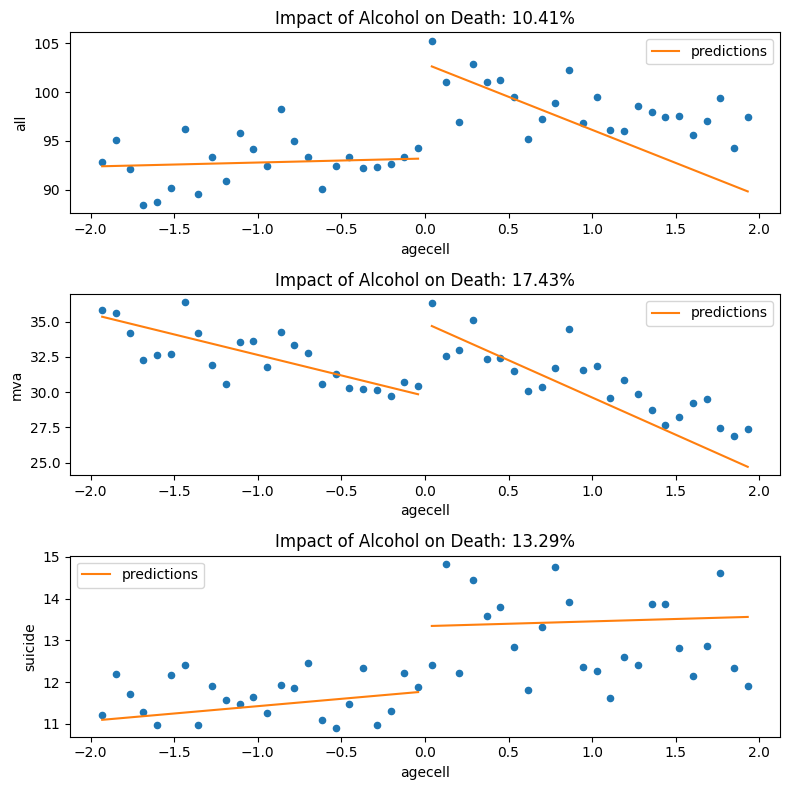

In [15]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

With the exception of suicide, it looks like adding the kernel weight made the negative impact on alcohol bigger. Once again, if we want to minimize the death rate, we should NOT recommend lowering the legal drinking age, since there is a clear impact of alcohol on the death rates.

This simple case covers what happens when regression discontinuity design works perfectly. Next, we will see some diagnostics that we should run in order to check how much we can trust RDD and talk about a topic that is very dear to our heart: the effect of education on earnings.



## Sheepskin Effect and Fuzzy RDD

When it comes to the effect of education on earnings, there are two major views in economics. The first one is the widely known argument that education increases human capital, increasing productivity and thus, earnings. In this view, education actually changes you for the better. Another view is that education is simply a signaling mechanism. It just puts you through all these hard tests and academic tasks. If you can make it, it signals to the market that you are a good employee. In this way, education doesn't make you more productive. It only tells the market how productive you have always been. What matters here is the diploma. If you have it, you will be paid more. We refer to this as the **sheepskin effect**, since diplomas were printed in sheepskin in the past.

To test this hypothesis, [Clark and Martorell](https://faculty.smu.edu/millimet/classes/eco7321/papers/clark%20martorell%202014.pdf) used regression discontinuity to measure the effect of graduating 12th grade on earnings. In order to do that, they had to think about some running variable where students that fall above it graduate and those who fall below it, don't. They found such data in the Texas education system.

In order to graduate in Texas, one has to pass an exam. Testing starts at 10th grade and students can do it multiple times, but eventually, they face a last chance exam at the end of 12th grade. The idea was to get data from students who took those last chance exams and compare those that had barely failed it to those that barely passed it. These students will have very similar human capital, but different signaling credentials. Namely, those that barely passed it, will receive a diploma. 

In [18]:
sheepskin = pd.read_csv("data_book/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


Once again, this data is grouped by the running variable. It contains not only the running variable (minscore, already centered at zero) and the outcome (avgearnings), but it also has the probability of receiving a diploma in that score cell and the size of the call (n). So, for example, out of the 12 students in the cell -30 below the score threshold, only 5 were able to get the diploma (12 * 0,416). 

This means that there is some slippage in the treatment assignment. Some students that are below the passing threshold managed to get the diploma anyway. Here, the regression discontinuity is **fuzzy**, rather than sharp. Notice how the probability of getting the diploma doesn't jump from zero to one at the threshold. But it does jump from something like 50% to 90%.

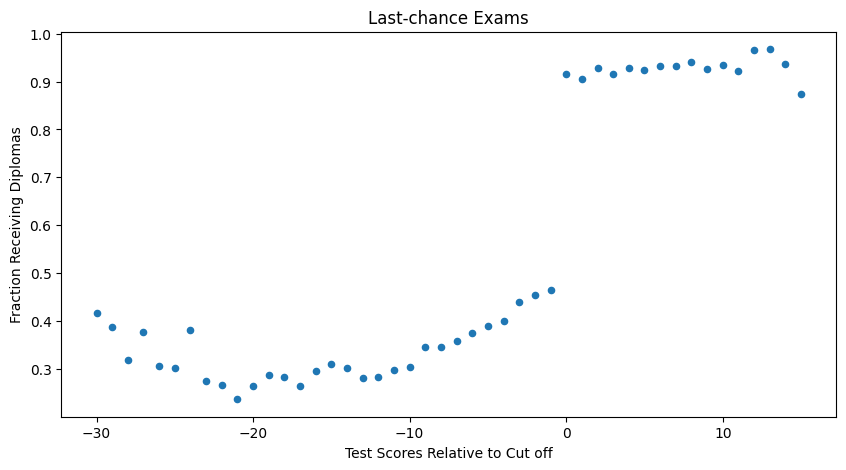

In [19]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

We can think of fuzzy RD as a sort of non compliance. Passing the threshold should make everyone receive the diploma, but some students, the never takers, don’t get it. Likewise, being below the threshold should prevent you from getting a diploma, but some students, the always takers, manage to get it anyway. 

Just like when we have the potential outcome, we have the potential treatment status in this situation. $T_1$ is the treatment everyone would have received had they been above the threshold. $T_0$ is the treatment everyone would have received had they been below the threshold. As you've might have noticed, we can think of the **threshold as an Instrumental Variable**. Just as in IV, if we naively estimate the treatment effect, it will be biased towards zero. 

![img](rdd/rdd_fuzzy.png)

The probability of treatment being less than one, even above the threshold, makes the outcome we observe less than the true potential outcome $Y_1$. By the same token, the outcome we observe below the threshold is higher than the true potential outcome $Y_0$. This makes it look like the treatment effect at the threshold is smaller than it actually is and we will have to use IV techniques to correct for that.

Just like when we've assumed smoothness on the potential outcome, we now assume it for the potential treatment. Also, we need to assume monotonicity, just like in IV. In case you don't remember, it states that $T_{i1}>T_{i0} \ \forall i$. This means that crossing the threshold from the left to the right only increases your chance of getting a diploma (or that there are no defiers). With these 2 assumptions, we have a Wald Estimator for LATE.

$$
\dfrac{\lim_{r \to c^+} E[Y_i|R_i=r] - \lim_{r \to c^-} E[Y_i|R_i=r]}{\lim_{r \to c^+} E[T_i|R_i=r] - \lim_{r \to c^-} E[T_i|R_i=r]} = E[Y_{1i} - Y_{0i} | T_{1i} > T_{0i}, R_i=c]
$$

Notice how this is a local estimate in two senses. First, it is local because it only gives the treatment effect at the threshold $c$. This is the RD locality. Second, it is local because it only estimates the treatment effect for the compliers. This is the IV locality.

To estimate this, we will use 2 linear regression. The numerator can be estimated just like we've done before. To get the denominator, we simply replace the outcome with the treatment. But first, let's talk about a sanity check we need to run to make sure we can trust our RDD estimates.

### The McCrary Test

One thing that could break our RDD argument is if people can manipulate where they stand at the threshold. In the sheepskin example this could happen if students just below the threshold found a way around the system to increase their test score by just a bit. Another example is when you need to be below a certain income level to get a government benefit. Some families might lower their income on purpose, just to be just eligible for the program.

In these sorts of situations, we tend to see a phenomenon called bunching on the density of the running variable. This means that we will have a lot of entities just above or just below the threshold. To check for that, we can plot the density function of the running variable and see if there are any spikes around the threshold. For our case, the density is given by the `n` column in our data.

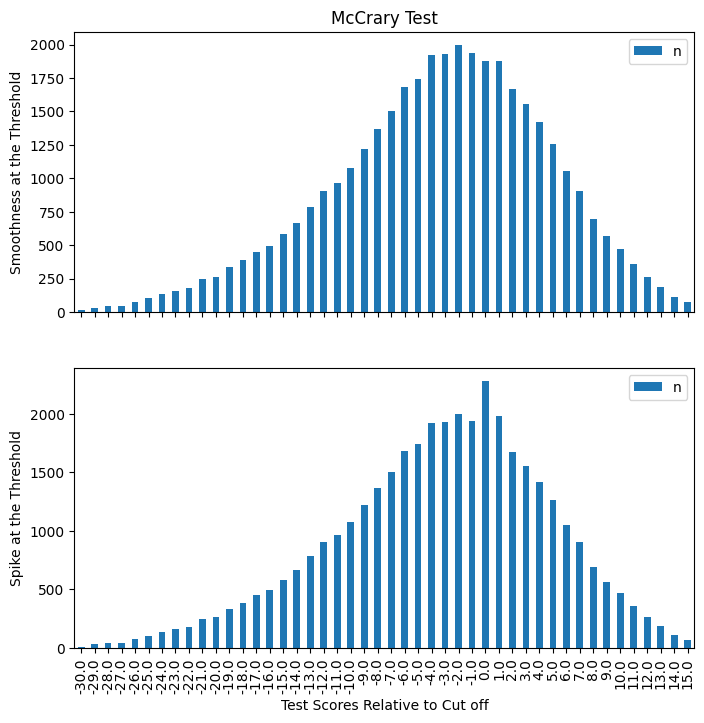

In [20]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

The first plot shows how our data density looks like. As we can see, there are no spikes around the threshold, meaning there is no bunching. Students are not manipulating where they fall on the threshold. Just for illustrative purposes, the second plot shows what bunching would look like if students could manipulate where they fall on the threshold. We would see a spike in the density for the cells just above the threshold, since many students would be on that cell, barely passing the exam. 

Getting this out of the way, we can go back to estimate the sheepskin effect. As I've said before, the numerator of the Wald estimator can be estimated just like we did in the Sharp RD. Here, we will use as weight the kernel with a bandwidth of 15. Since we also have the cell size, we will multiply the kernel by the sample size to get a final weight for the cell. 

In [21]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"] > 0).astype(int))
model = smf.wls("avgearnings ~ minscore * threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


This is telling us that the effect of a diploma is -97.7571, but this is not statistically significant (P-value of 0.5). If we plot these results, we get a very continuous line at the threshold. More educated people indeed make more money, but there isn't a jump at the point where they receive the 12th grade diploma. This is an argument in favor of the view that says that education increases earnings by making people more productive, rather than being just a signal to the marker. In other words, there is no sheepskin effect. 

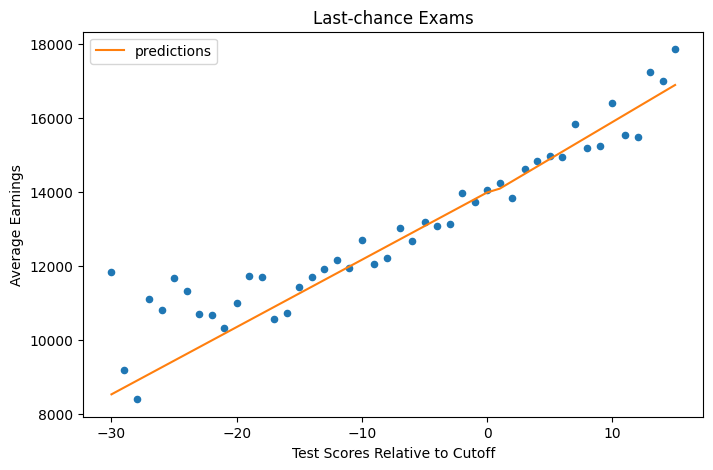

In [22]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

However, as we know from the way non compliance bias works, this result is biased towards zero. To correct for that, we need to scale it by the first stage and get the Wald estimator. Unfortunately, there isn't a good Python implementation for this, so we will have to do it manually and use bootstrap to get the standard errors.

The code below runs the numerator of the Wald estimator just like we did before and also constructs the denominator by replacing the target variable with the treatment variable `receivehsd`. The final step just divides the numerator by the denominator. 


Note: Wald estimator is the estimated coefficient of instrument by divided by the percentage of people affected by the instrument.

In [24]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd ~ minscore * threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings ~ minscore * threshold", data, weights=weights).fit()
    return numerator.params["threshold"] / denominator.params["threshold"]

In [25]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

With the bootstrap samples, we can plot the distribution of ATEs and see where the 95% confidence interval is.

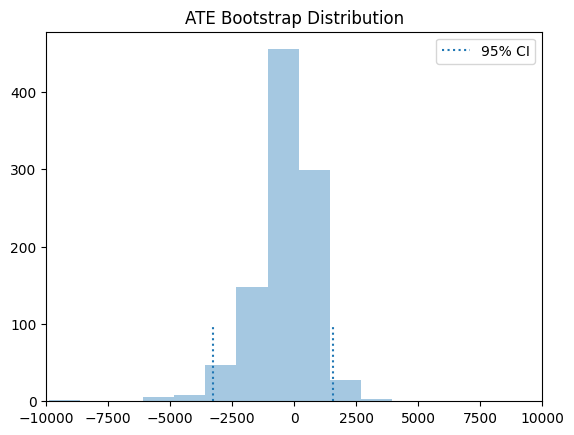

In [26]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();